In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import data_handling
import utils
from gaussian_spectral_clustering import (compute_pcs_and_project,
                                          initial_class_assignment,
                                          iterate_clustering,
                                          compute_class_statistics,
                                          compute_posterior_probability_and_assign,
                                          compute_multivariate_gaussian_statistics
                                         )
%matplotlib inline



In [3]:
# matplotlib settings for figure size and colormap
plt.rcParams['figure.figsize'] = [20, 15];
plt.rcParams['image.cmap'] = plt.gray();

<Figure size 1440x1080 with 0 Axes>

In [4]:
data_path = r'C:\Users\Jon\PycharmProjects\gaussian-spectral-clustering\ECE567_data_package_1\\'
img_filename = data_path + '20130408_155259_archer_hsi_0021_crop_NUC_ELM.dat'
img_truth_filename = data_path + '20130408_155259_archer_hsi_0021_truth.dat'

In [5]:
hsi_data_mat, sz, truth_data_mat = data_handling.load_archer_data(img_filename, img_truth_filename)

C:\Users\Jon\Miniconda3\envs\ece567\lib\site-packages\spectral\io\envi.py:195: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.setttings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Header parameter names converted to lower case.


In [6]:
# Get indices for each class in the truth
blue_serials = list(range(30,35)) + list(range(40,45))\
                + list(range(60,65)) + list(range(50,53))

brown_serials = list(range(35,40)) + list(range(45,50))\
                 + list(range(65,70)) + list(range(55,58))
camo_serials = list(range(20,25))

print('Blue serial numbers:', blue_serials)
print('Brown serial numbers:', brown_serials)
print('Camo serial numbers:', camo_serials)

blue_ix = data_handling.serials_to_idxs(blue_serials, truth_data_mat)
brown_ix = data_handling.serials_to_idxs(brown_serials, truth_data_mat)
camo_ix = data_handling.serials_to_idxs(camo_serials, truth_data_mat)

background_ix = data_handling.serials_to_idxs([0], truth_data_mat)
white_ix = data_handling.serials_to_idxs([10], truth_data_mat)
black_ix = data_handling.serials_to_idxs([11], truth_data_mat)

print('Num blue pixels:', blue_ix.shape[0])
print('Num brown pixels:', brown_ix.shape[0])
print('Num background pixels:', background_ix.shape[0])
print('Num camo pixels:', camo_ix.shape[0])
print('Num white pixels:', white_ix.shape[0])
print('Num black pixels:', black_ix.shape[0])

Blue serial numbers: [30, 31, 32, 33, 34, 40, 41, 42, 43, 44, 60, 61, 62, 63, 64, 50, 51, 52]
Brown serial numbers: [35, 36, 37, 38, 39, 45, 46, 47, 48, 49, 65, 66, 67, 68, 69, 55, 56, 57]
Camo serial numbers: [20, 21, 22, 23, 24]
Num blue pixels: 276
Num brown pixels: 217
Num background pixels: 503305
Num camo pixels: 164
Num white pixels: 19
Num black pixels: 19


## Compute PCs and Project

In [7]:
x_pca, eig_vecs = compute_pcs_and_project(hsi_data_mat)

In [8]:
def reshape_pca_band(X, band, sz):
    nl, ns, nb = sz
    # return X.transpose().reshape([nl, ns, nb], order='F')[:, :, band]
    return X[band, :].reshape([nl, ns], order='F')

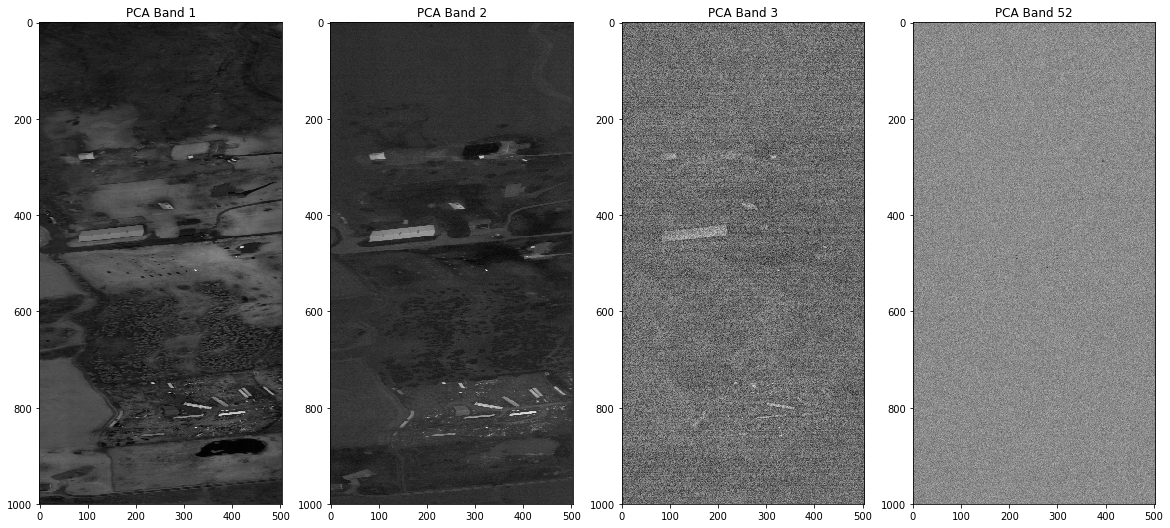

In [9]:
# Plot various bands from the image
# Squeeze() is needed to remove the single-dimensional band dimension
# before plotting (e.g. (nl, ns, 1) -> (nl, ns))
f, (plot1, plot2, plot3, plot4) = plt.subplots(1, 4)
plot1.imshow(reshape_pca_band(x_pca, 0, sz), cmap=plt.gray());
plot1.set_title('PCA Band 1');

plot2.imshow(reshape_pca_band(x_pca, 1, sz), cmap=plt.gray());
plot2.set_title('PCA Band 2');

plot3.imshow(reshape_pca_band(x_pca, 2, sz), cmap=plt.gray());
plot3.set_title('PCA Band 3');

plot4.imshow(reshape_pca_band(x_pca, 51, sz), cmap=plt.gray());
plot4.set_title('PCA Band 52');

## Split data into leading and trailing-order PCs
### Try it out on all of the data, as well as a masked version where only the background ("natural") pixels are used for mean/covariance calculations

In [10]:
# Number of leading order PCs (i.e. bands [0, K])
K = 10

leading_order_pcs = x_pca[:K, :]
trailing_order_pcs = x_pca[K:, :]

In [11]:
background_mask = np.ones_like(leading_order_pcs)
background_mask[:, background_ix] = 0
leading_order_pcs_masked = leading_order_pcs[:, background_ix]#np.ma.MaskedArray(leading_order_pcs, background_mask)

background_mask = np.ones_like(hsi_data_mat)
background_mask[:, background_ix] = 0
hsi_data_mat_masked = hsi_data_mat[:, background_ix]#np.ma.MaskedArray(hsi_data_mat, background_mask)
#np.ma.set_fill_value(hsi_data_mat_masked, np.nan)
#hsi_data_mat_masked[:, background_ix] = np.nan

## (Optional) Cull Pixels

In [12]:
#outlier_ixs = compute_multivariate_gaussian_statistics(trailing_order_pcs)

In [13]:
#leading_order_pcs = np.delete(leading_order_pcs, outlier_ixs, axis=1)

## Initial Class Assignment (leading-order PCs)

In [14]:
num_classes = 7

In [15]:
np.random.seed(12345)
cmi, cm, cc = initial_class_assignment(leading_order_pcs, num_classes)

In [16]:
np.random.seed(12345)
cmi_masked, cm_masked, cc_masked = initial_class_assignment(leading_order_pcs_masked, num_classes)

In [17]:
#cmi, cm, cc = initial_class_assignment(leading_order_pcs, num_classes, method='select', init_indices=[blue_ix[0], brown_ix[0], camo_ix[0], white_ix[0], black_ix[0], background_ix[500], background_ix[50000]])

## Iterate through GSC Algorithm

In [18]:
np.random.seed(12345)
final_class_ixs = iterate_clustering(leading_order_pcs, cmi, num_classes, 500, dead_class_threshold=10)

class counts [72717 71753 71649 71875 72142 71951 71913]
Finished iteration # 0
class counts [69362 81536 82757 79319 72275 57116 61635]
Finished iteration # 1
class counts [69661 86745 91563 84529 72939 38393 60170]
Finished iteration # 2
class counts [66831 88352 97689 86452 69628 34319 60729]
Finished iteration # 3
class counts [ 64166  88657 101092  86608  65993  31416  66068]
Finished iteration # 4
class counts [ 62548  89916 102476  85458  62415  27554  73633]
Finished iteration # 5
class counts [ 62224  94848 102022  83222  59192  23691  78801]
Finished iteration # 6
class counts [ 62892 104930  98835  80311  56558  20633  79841]
Finished iteration # 7
class counts [ 63838 119885  93018  76641  54533  18384  77701]
Finished iteration # 8
class counts [ 64651 136300  86363  72709  53302  16652  74023]
Finished iteration # 9
class counts [ 65637 148738  81185  70035  52888  15426  70091]
Finished iteration # 10
class counts [ 67155 155147  78524  68649  53062  14503  66960]
Finish

class counts [ 23630 142707  94898  81526  87172  10647  63420]
Finished iteration # 94
class counts [ 23631 142546  94988  81858  86992  10629  63356]
Finished iteration # 95
class counts [ 23637 142361  95072  82161  86847  10610  63312]
Finished iteration # 96
class counts [ 23639 142198  95151  82440  86686  10605  63281]
Finished iteration # 97
class counts [ 23642 142030  95267  82683  86522  10620  63236]
Finished iteration # 98
class counts [ 23643 141867  95384  82957  86322  10626  63201]
Finished iteration # 99
class counts [ 23654 141708  95498  83182  86161  10636  63161]
Finished iteration # 100
class counts [ 23664 141556  95633  83354  86017  10635  63141]
Finished iteration # 101
class counts [ 23676 141419  95735  83569  85845  10636  63120]
Finished iteration # 102
class counts [ 23691 141266  95849  83787  85673  10646  63088]
Finished iteration # 103
class counts [ 23707 141094  95966  83995  85536  10656  63046]
Finished iteration # 104
class counts [ 23729 140926

class counts [ 23393 132084  93317 103362  76586  10666  64592]
Finished iteration # 187
class counts [ 23394 132066  93299 103394  76576  10677  64594]
Finished iteration # 188
class counts [ 23396 132046  93286 103419  76571  10691  64591]
Finished iteration # 189
class counts [ 23395 132031  93260 103459  76564  10699  64592]
Finished iteration # 190
class counts [ 23392 132014  93250 103463  76578  10707  64596]
Finished iteration # 191
class counts [ 23389 131999  93250 103478  76576  10708  64600]
Finished iteration # 192
class counts [ 23389 131992  93249 103489  76561  10715  64605]
Finished iteration # 193
class counts [ 23389 131982  93252 103492  76556  10710  64619]
Finished iteration # 194
class counts [ 23389 131968  93253 103496  76559  10704  64631]
Finished iteration # 195
class counts [ 23390 131953  93253 103491  76571  10699  64643]
Finished iteration # 196
class counts [ 23391 131941  93247 103490  76576  10704  64651]
Finished iteration # 197
class counts [ 23391 

class counts [ 23330 131172  92402 105338  76094  10683  64981]
Finished iteration # 280
class counts [ 23330 131175  92393 105345  76093  10683  64981]
Finished iteration # 281
class counts [ 23330 131176  92378 105359  76094  10682  64981]
Finished iteration # 282
class counts [ 23330 131175  92372 105358  76101  10683  64981]
Finished iteration # 283
class counts [ 23330 131174  92371 105358  76101  10685  64981]
Finished iteration # 284
class counts [ 23329 131174  92374 105351  76105  10688  64979]
Finished iteration # 285
class counts [ 23329 131174  92370 105355  76106  10687  64979]
Finished iteration # 286
class counts [ 23329 131175  92369 105356  76104  10688  64979]
Finished iteration # 287
class counts [ 23329 131176  92371 105354  76099  10690  64981]
Finished iteration # 288
class counts [ 23329 131171  92377 105348  76104  10685  64986]
Finished iteration # 289
class counts [ 23329 131166  92379 105347  76108  10679  64992]
Finished iteration # 290
class counts [ 23329 

class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 373
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 374
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 375
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 376
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 377
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 378
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 379
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 380
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 381
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 382
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 383
class counts [ 23324 

class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 466
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 467
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 468
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 469
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 470
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 471
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 472
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 473
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 474
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 475
class counts [ 23324 131125  92305 105414  76161  10667  65004]
Finished iteration # 476
class counts [ 23324 

In [19]:
np.random.seed(12345)
final_class_ixs_masked = iterate_clustering(leading_order_pcs_masked, cmi_masked, num_classes, 500, dead_class_threshold=10)

class counts [72879 71321 71232 71638 72013 72093 72129]
Finished iteration # 0
class counts [60222 72623 74054 65198 60654 87037 83517]
Finished iteration # 1
class counts [39029 74852 76854 63621 56820 98718 93411]
Finished iteration # 2
class counts [ 33382  72961  76420  59395  54360 106692 100095]
Finished iteration # 3
class counts [ 30947  71291  74388  56735  54641 111433 103870]
Finished iteration # 4
class counts [ 28064  69804  71313  55874  56690 116305 105255]
Finished iteration # 5
class counts [ 24682  68582  67849  55642  58548 122120 105882]
Finished iteration # 6
class counts [ 21633  67235  65027  55547  59138 127716 107009]
Finished iteration # 7
class counts [ 19307  65654  62516  55556  58540 132932 108800]
Finished iteration # 8
class counts [ 17592  63432  60795  55174  57515 137917 110880]
Finished iteration # 9
class counts [ 16256  60709  60117  54151  56394 143355 112323]
Finished iteration # 10
class counts [ 15254  58055  60599  53083  55082 148431 112801]

class counts [ 10872  86447  97808  23578  58931 141991  83678]
Finished iteration # 94
class counts [ 10876  86426  97770  23590  58913 141866  83864]
Finished iteration # 95
class counts [ 10883  86446  97703  23575  58912 141738  84048]
Finished iteration # 96
class counts [ 10886  86453  97637  23578  58899 141614  84238]
Finished iteration # 97
class counts [ 10887  86460  97557  23597  58885 141494  84425]
Finished iteration # 98
class counts [ 10885  86469  97482  23593  58862 141385  84629]
Finished iteration # 99
class counts [ 10881  86499  97404  23595  58848 141267  84811]
Finished iteration # 100
class counts [ 10880  86493  97339  23618  58859 141125  84991]
Finished iteration # 101
class counts [ 10881  86445  97305  23627  58901 140975  85171]
Finished iteration # 102
class counts [ 10882  86393  97286  23615  58914 140837  85378]
Finished iteration # 103
class counts [ 10884  86349  97251  23591  58915 140715  85600]
Finished iteration # 104
class counts [ 10884  86322

class counts [ 10929  82884  93040  23082  59458 133637 100275]
Finished iteration # 187
class counts [ 10930  82890  93030  23077  59452 133627 100299]
Finished iteration # 188
class counts [ 10930  82888  93025  23075  59453 133609 100325]
Finished iteration # 189
class counts [ 10931  82896  93000  23074  59466 133586 100352]
Finished iteration # 190
class counts [ 10931  82917  92968  23068  59484 133562 100375]
Finished iteration # 191
class counts [ 10931  82929  92947  23067  59493 133546 100392]
Finished iteration # 192
class counts [ 10931  82935  92935  23062  59500 133526 100416]
Finished iteration # 193
class counts [ 10930  82956  92905  23063  59508 133510 100433]
Finished iteration # 194
class counts [ 10930  82967  92887  23065  59518 133488 100450]
Finished iteration # 195
class counts [ 10930  82968  92879  23059  59536 133462 100471]
Finished iteration # 196
class counts [ 10930  82971  92866  23059  59556 133439 100484]
Finished iteration # 197
class counts [ 10929 

class counts [ 10887  83028  92497  23106  59995 132969 100823]
Finished iteration # 280
class counts [ 10886  83030  92495  23105  59996 132968 100825]
Finished iteration # 281
class counts [ 10885  83029  92498  23104  59999 132967 100823]
Finished iteration # 282
class counts [ 10884  83028  92500  23106  60004 132966 100817]
Finished iteration # 283
class counts [ 10883  83024  92500  23107  60012 132962 100817]
Finished iteration # 284
class counts [ 10883  83022  92495  23106  60021 132960 100818]
Finished iteration # 285
class counts [ 10883  83016  92491  23106  60027 132962 100820]
Finished iteration # 286
class counts [ 10883  83011  92487  23105  60027 132968 100824]
Finished iteration # 287
class counts [ 10883  83005  92483  23104  60030 132971 100829]
Finished iteration # 288
class counts [ 10883  83004  92478  23104  60029 132972 100835]
Finished iteration # 289
class counts [ 10882  83001  92476  23104  60031 132973 100838]
Finished iteration # 290
class counts [ 10880 

class counts [ 10864  82981  92557  23161  59824 132888 101030]
Finished iteration # 373
class counts [ 10864  82982  92552  23161  59825 132887 101034]
Finished iteration # 374
class counts [ 10864  82983  92551  23159  59823 132888 101037]
Finished iteration # 375
class counts [ 10864  82981  92547  23162  59825 132886 101040]
Finished iteration # 376
class counts [ 10864  82983  92545  23163  59823 132885 101042]
Finished iteration # 377
class counts [ 10864  82984  92544  23163  59822 132882 101046]
Finished iteration # 378
class counts [ 10864  82987  92542  23164  59824 132877 101047]
Finished iteration # 379
class counts [ 10864  82985  92545  23161  59824 132873 101053]
Finished iteration # 380
class counts [ 10864  82986  92541  23158  59826 132873 101057]
Finished iteration # 381
class counts [ 10864  82982  92540  23160  59830 132869 101060]
Finished iteration # 382
class counts [ 10863  82980  92540  23158  59833 132868 101063]
Finished iteration # 383
class counts [ 10863 

class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 466
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 467
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 468
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 469
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 470
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 471
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 472
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 473
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 474
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 475
class counts [ 10855  83045  92610  23116  60037 132634 101008]
Finished iteration # 476
class counts [ 10855 

In [20]:
# Code taken from https://github.com/bids/colormap/blob/master/parula.py to create the Parula colormap
# Parula is MATLAB's default and is being used to better compare this Python code to the MATLAB results given
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

plt.register_cmap(cmap=parula_map)
cmap = plt.get_cmap('parula')

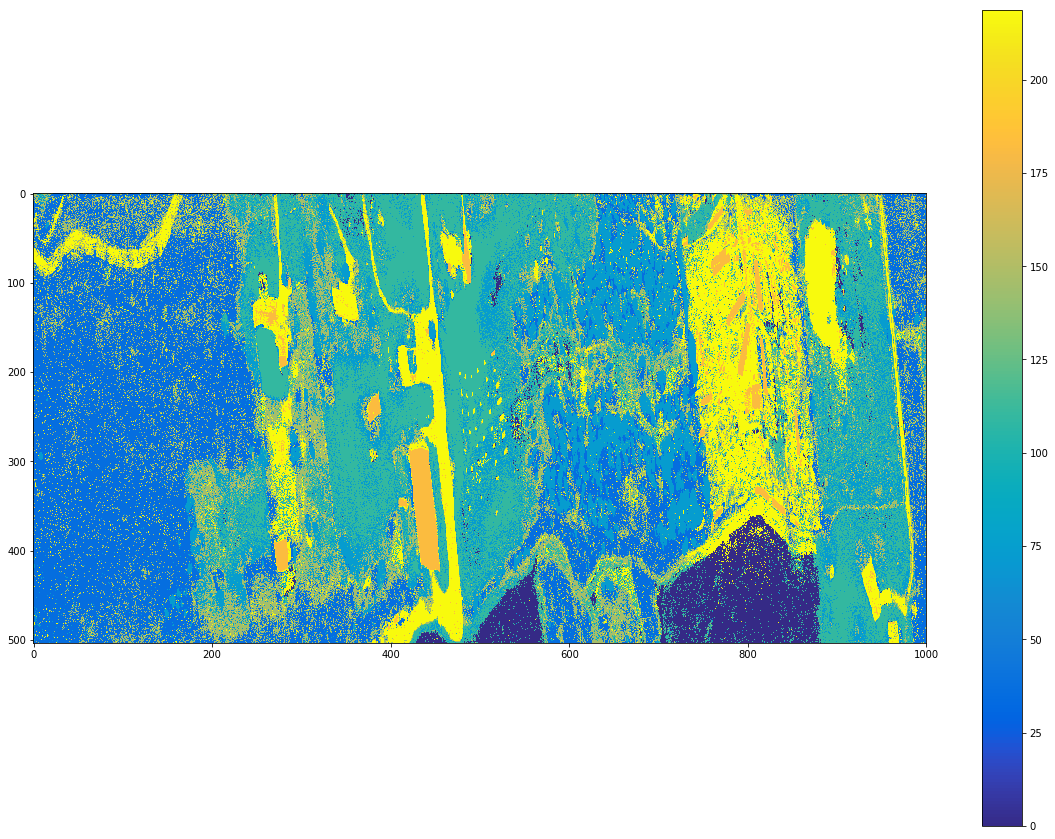

In [21]:
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

im = axs.imshow(np.rot90(final_class_ixs.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

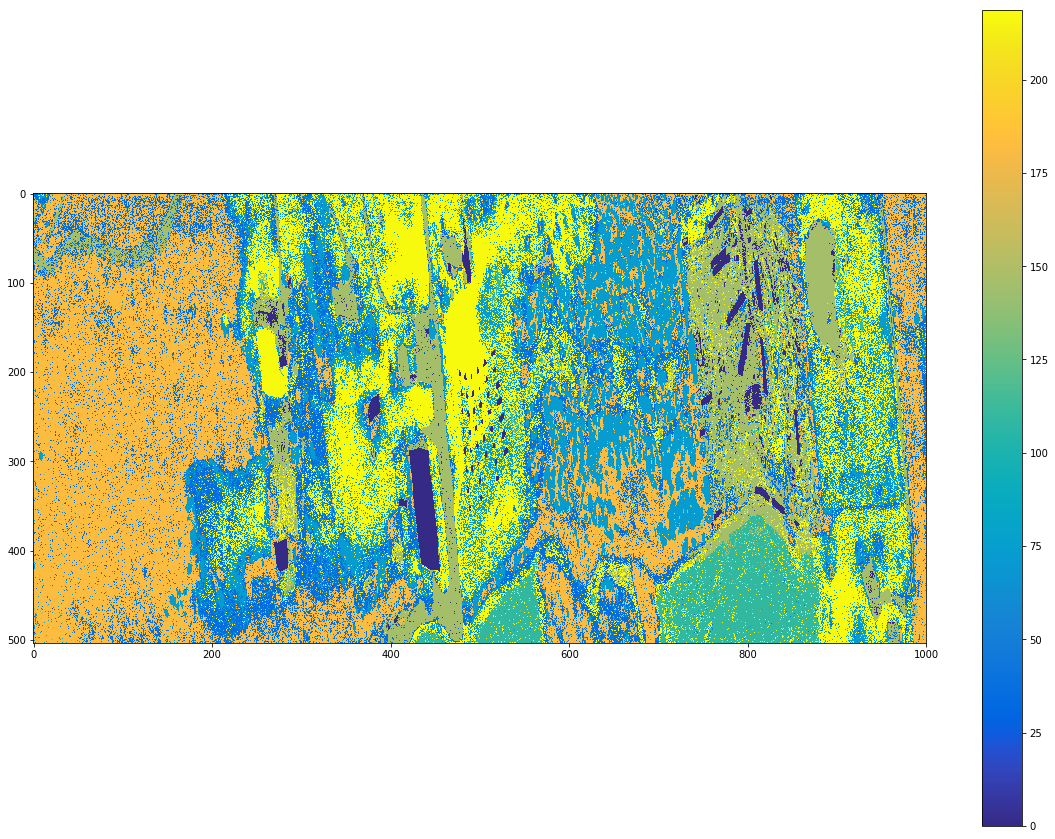

In [22]:
tmp = np.zeros([nl*ns])
tmp[background_ix] = final_class_ixs_masked
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

#im = axs.imshow(np.rot90(final_class_ixs_masked.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
im = axs.imshow(np.rot90(tmp.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

In [23]:
from sklearn.cluster import KMeans

In [24]:
km = KMeans(n_clusters=num_classes, random_state=12345).fit(hsi_data_mat.transpose())

In [ ]:

km_masked = KMeans(n_clusters=num_classes, random_state=12345).fit(hsi_data_mat_masked.transpose())

In [ ]:
nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

im = axs.imshow(np.rot90(km.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

In [ ]:
tmp = np.zeros([nl*ns])
tmp[background_ix] = km_masked.labels_
#background_ix

nl, ns, nb = sz
fig, axs = plt.subplots(nrows=1, ncols=1);
cmap = plt.get_cmap('parula')

#im = axs.imshow(np.rot90(km_masked.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
im = axs.imshow(np.rot90(tmp.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

fig.colorbar(im, ax=axs);

In [ ]:
# Side by side comparison
fig, axs = plt.subplots(nrows=2, ncols=1);
cmap = plt.get_cmap('parula')

gsc_im = axs[0].imshow(np.rot90(final_class_ixs.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);
km_im = axs[1].imshow(np.rot90(km.labels_.reshape([nl, ns], order='F') * 255/num_classes), cmap=cmap);

axs[0].set_title('AVIRIS Gaussian Spectral Clustering ({} classes)'.format(num_classes))
axs[1].set_title('AVIRIS K-Means ({} classes)'.format(num_classes))
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(gsc_im, ax=axs);